## Decoupled dynamics - comparing exact and approximate solutions

In [25]:
import os
from pathlib import Path
import numpy as np
from scipy.integrate import solve_ivp

from matplotlib import pyplot as plt
import tikzplotlib

In [26]:
# Exact dynamics, approximate solution
# TODO: ändrade att r = 2\eta till r=\eta, kan vara bra att dubbelkolla uttrycken

def dudt(t, u, c, r, s, l):
    
    return np.sqrt(c**2 + 4 * r**2 * u**2) * (s - l * u)


def solve_dynamics(u0, t, c, r, s, l): 
    
    u0 = np.ma.atleast_1d(u0)
    res = solve_ivp(dudt, (0, max(t)), u0, t_eval=t, args = (c, r, s, l))
    
    if not res["success"]:
        stat, msg = res.get("status"), res.get("message")
        print(f"ODE solver not successful. Termination {stat}. Message: {msg}")
    
    return res["y"].squeeze()


def loop_dynamics(u0, t, c, r, s, l, q="l"):
    
    assert q in ["l", "s", "u0", "rc"], "Unknown model quantity"
    
    u_traj = []
    if q == "l":
        for lx in l:
            u_traj.append(solve_dynamics(u0, t, c, r, s, lx))
    elif q == "s":
        for sx in s:
            u_traj.append(solve_dynamics(u0, t, c, r, sx, l))
    elif q == "u0":
        for u0x in u0:
            u_traj.append(solve_dynamics(u0x, t, c, r, s, l))
    else:
        assert len(c) == len(r), "c and r need to be equal length"
        for cx, rx in zip(c, r):
            u_traj.append(solve_dynamics(u0, t, cx, rx, s, l))
        
    return np.row_stack(u_traj)


In [27]:
# Approximate dynamics

def solution_time(u, u0, c, r, k1, k2, s, l):
    # Time to reach point u from u0 in approximate dynamics
    
    n = np.log((k1 * c + 2 * k2 * r * u) / (k1 * c + 2 * k2 * r * u0)) + np.log((s - l * u0) / (s - l * u)) 
    d = k1 * c * l + 2 * k2 * r * s
  
    return n / d


def f(u0, t, c, r, k1, k2, s, l):
    # Approximate dynamics not covering "break point"
    
    n = s * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) + k1 * c * (l * u0 - s)
    d = l * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) - 2 * k2 * r * (l * u0 - s)
    
    return n / d


def u_approx(u0, t, c, r, s, l):
    
    if (2 * u0 * r) < c: 
        
        # Give c larger weight in approximation (to begin with)
        k1, k2 = 0.96, 0.4
        u = f(u0, t, c, r, k1, k2, s, l)
        
        if not np.isscalar(t) and ((2 * u[-1] * r) >= c): # If we passed breaking point
            
            # Find time where we meet breaking point
            t_break = solution_time(c / (2 * r), u0, c, r, k1, k2, s, l)
            
            # Use "reversed" approximation for remaining time steps
            ref = ((2 * u * r) >= c)
            u[ref] = f(c / (2 * r), t[ref] - t_break, c, r, k2, k1, s, l)
               
    else:
        
        # Give r larger weight in approximation (to begin with)
        k1, k2 = 0.4, 0.96
        u = f(u0, t, c, r, k1, k2, s, l)

        if not np.isscalar(t) and ((2 * u[-1] * r) < c): #  If we passed breaking point

            # Find time where we meet breaking point
            t_break = solution_time(c / (2 * r), u0, c, r, k1, k2, s, l)

            # Use "reversed" approximation for remaining time steps
            ref = ((2 * u * r) < c)
            u[ref] = f(c / (2 * r), t[ref] - t_break, c, r, k2, k1, s, l)
    
    return u


def loop_dynamics_approx(u0, t, c, r, s, l, q="l"):
    
    assert q in ["l", "s", "u0", "rc"], "Unknown model quantity"
    
    u_traj = []
    if q == "l":
        for lx in l:
            u_traj.append(u_approx(u0, t, c, r, s, lx))
    elif q == "s":
        for sx in s:
            u_traj.append(u_approx(u0, t, c, r, sx, l))
    elif q == "u0":
        for u0x in u0:
            u_traj.append(u_approx(u0x, t, c, r, s, l))
    else:
        assert len(c) == len(r), "c and r need to be equal length"
        for cx, rx in zip(c, r):
            u_traj.append(u_approx(u0, t, cx, rx, s, l))
        
    return np.row_stack(u_traj)

In [28]:
def plot_res(res1, res2, t_range, it_range, it="", titles=["Exact", "Approx.", "Rel. diff."], vmax=[None, None, None], log_x_scale=True, log_y_scale=True, fig_name="test"):
    
    assert len(vmax) == 3, "Need to specify vmax for all plots"
    
    fig, ax = plt.subplots(1, 3, figsize = (18, 5))
    
    if log_x_scale:
        new_ticks_x = np.linspace(0, res1.shape[0] - 1, int(np.log10(t_range.max())) + 1).astype(int)
    else:
        new_ticks_x = np.linspace(0, res1.shape[0] - 1, 5).astype(int)

    new_ticks_y = np.linspace(0, res1.shape[0] - 1, 5).astype(int)


    im1 = ax[0].imshow(res1, cmap="viridis", vmax=vmax[0])
    im2 = ax[1].imshow(res2, cmap="viridis", vmax=vmax[1])
    im3 = ax[2].imshow(np.abs((res1-res2)/res1), cmap="viridis", vmax=vmax[2])
    
    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    fig.colorbar(im3, ax=ax[2])
    
    for i in range(3):
        ax[i].set_title(titles[i]) 
        
        ax[i].set_xlabel("t")
        ax[i].set_xticks(new_ticks_x)
        
        if log_x_scale:
            ax[i].set_xticklabels([f"$10^{{{x}}}$" for x in np.round(np.log10(t_range[new_ticks_x]), 1).astype(int)]) # OBS: AVRUNDNINGEN!!!
        else:
            ax[i].set_xticklabels(t_range[new_ticks_x].astype(int)) 

        ax[i].set_ylabel(it)
        ax[i].set_yticks(new_ticks_y)
        
        if log_y_scale:
            ax[i].set_yticklabels([f"10^{{{x}}}" for x in np.round(np.log10(it_range[new_ticks_y]), 2)]) # OBS: AVRUNDNINGEN!!!
        else:
            ax[i].set_yticklabels(np.round(it_range[new_ticks_y], 2)) # OBS: AVRUNDNINGEN!!!
            
    savedir="res/comp_dynamics/"
    if not os.path.exists(Path(savedir)):
        os.mkdir(Path(savedir))
            
    #tikzplotlib.save(Path(savedir + fig_name + "_surface_plot.tikz"))
    plt.savefig(Path(savedir + fig_name + "_surface_plot.png"))
    
    plt.show()
    
def plot_curves(res1, res2, t_range, it_range, it="", titles=["Exact", "Approx.", "Rel. diff."], ylim=[None, None, None], log_x_scale=True, log_y_scale=True, fig_name="test"):
    
    assert len(ylim) == 3, "Need to specify ylim for all plots"

    
    fig, ax = plt.subplots(1, 3, figsize = (18, 5))    
        
    for i in range(0, res1.shape[-1], int(res1.shape[-1] / 5)) :
        
        if log_y_scale:
            lab = it + " = " + fr"10^{{{np.round(np.log10(it_range[i]), 2)}}}"
        else:
            lab = it + " = " + str(round(it_range[i], 2))
            
        ax[0].plot(t_range, res1[i, :], label=lab)
        ax[1].plot(t_range, res2[i, :], label=lab)
        ax[2].plot(t_range, np.abs((res1[i, :]-res2[i, :])/res1[i, :]), label=lab)
    
    for i in range(3):
                
        ax[i].set_title(titles[i]) 
        ax[i].legend(loc=2)

        
        ax[i].set_xlabel("t")
        ax[i].set_ylabel("u(t)")
        
        ax[i].set_ylim([0, ylim[i]])
        
        if log_x_scale:
            ax[i].set_xscale("log")

    savedir="res/comp_dynamics/"
    if not os.path.exists(Path(savedir)):
        os.mkdir(Path(savedir))
            
    #tikzplotlib.save(Path(savedir + fig_name + "_example_plots.tikz"))
    plt.savefig(Path(savedir + fig_name + "_example_plots.png"))
    
    plt.show()

# Exact dynamics, changing the learning rate

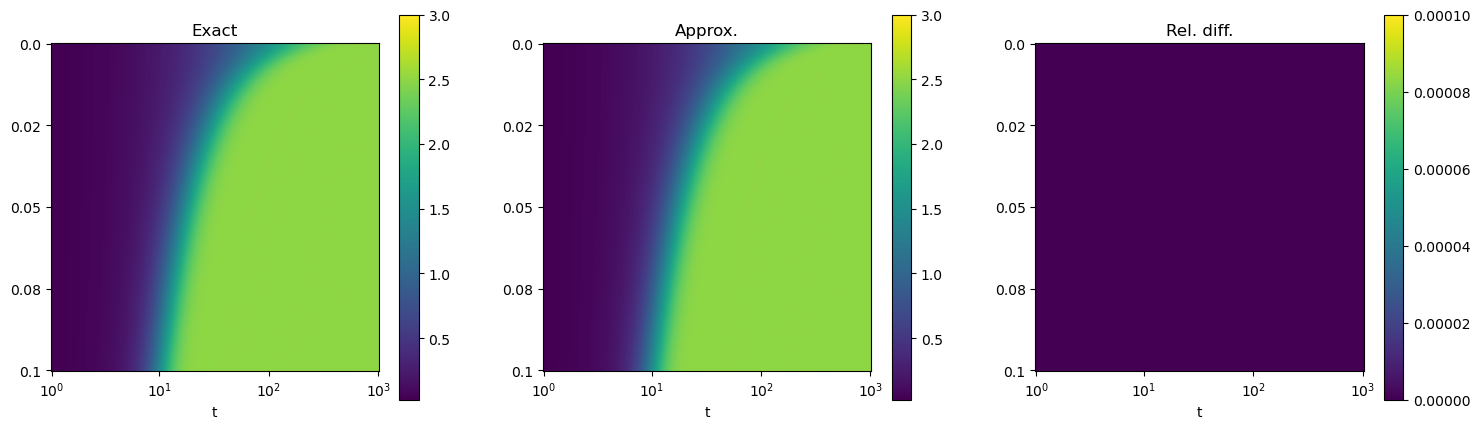

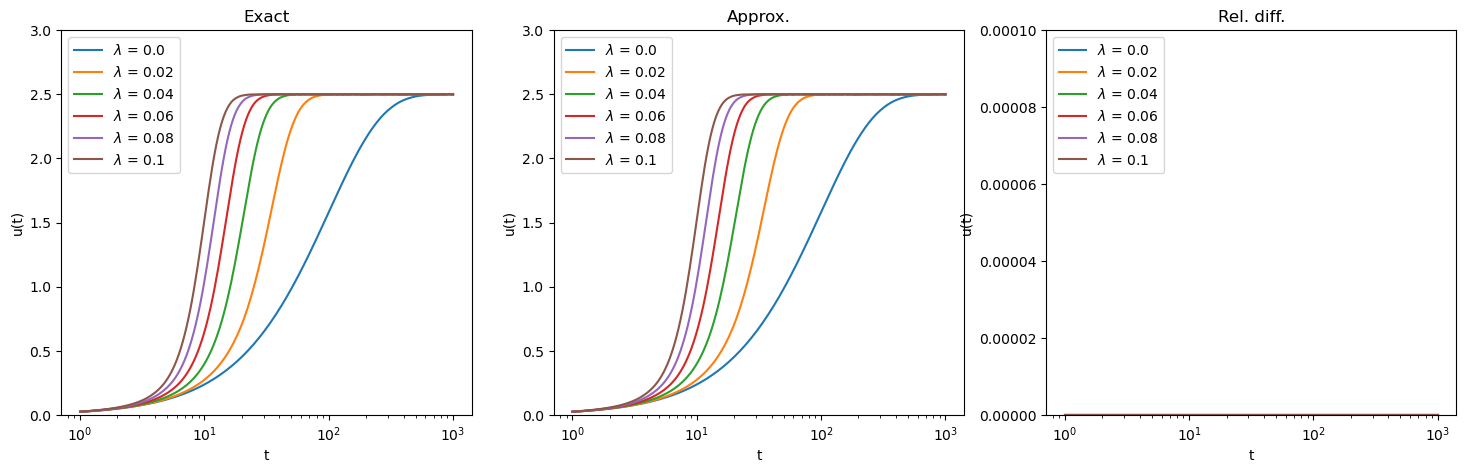

In [29]:
# Hps
tau = 1000
res = 201

c = 0.01
s = 2.5
l = 1
u0 = 0.001
e = 0.5

r_max = 0.1
t_range = np.geomspace(1, tau, res)
r_range = np.linspace(0, r_max, res)

# What happens when we change r?
u_ex = loop_dynamics(u0, t_range, [c] * r_range.shape[0], r_range, s, l, q="rc")

plot_res(u_ex, u_ex, t_range, r_range, vmax=[3.0, 3.0, 0.0001], log_y_scale=False)
plot_curves(u_ex, u_ex, t_range, it_range=r_range, it=r"$\lambda$", ylim=[3.0, 3.0, 0.0001], log_y_scale=False)

# Test example

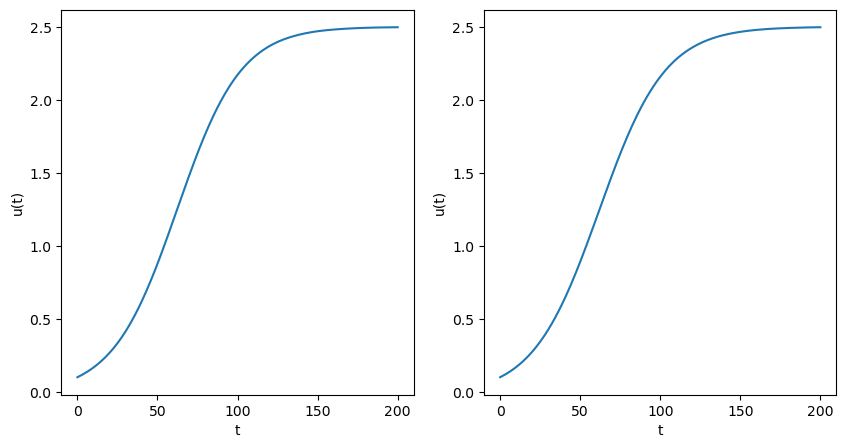

In [30]:
# Test

# Hps
tau = 200
ts = np.linspace(0, tau, tau)

c, r = 0.001, 0.01
s = 2.5
l = 1
u0 = 0.1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Exact
u_ex = solve_dynamics(u0, ts, c, r, s, l)
ax[0].plot(ts, u_ex)

# Approx. 
ax[1].plot(ts, u_approx(u0, ts, c, r, s, l)) 


for i in range(2):
    ax[i].set_xlabel("t")
    ax[i].set_ylabel("u(t)")

plt.show()

# Changing $l=\lambda$

# c < r

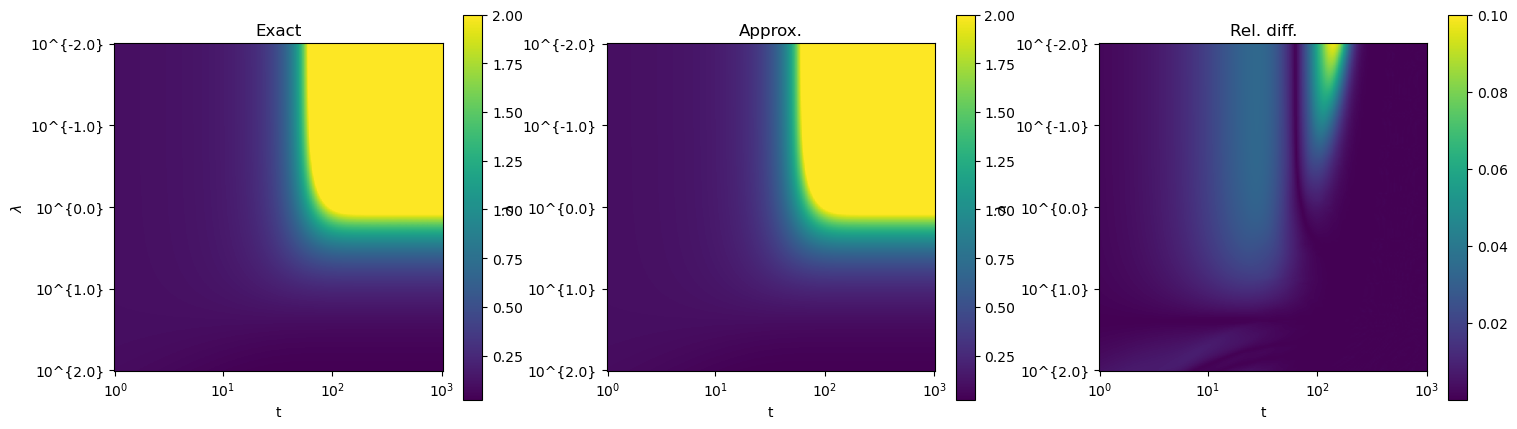

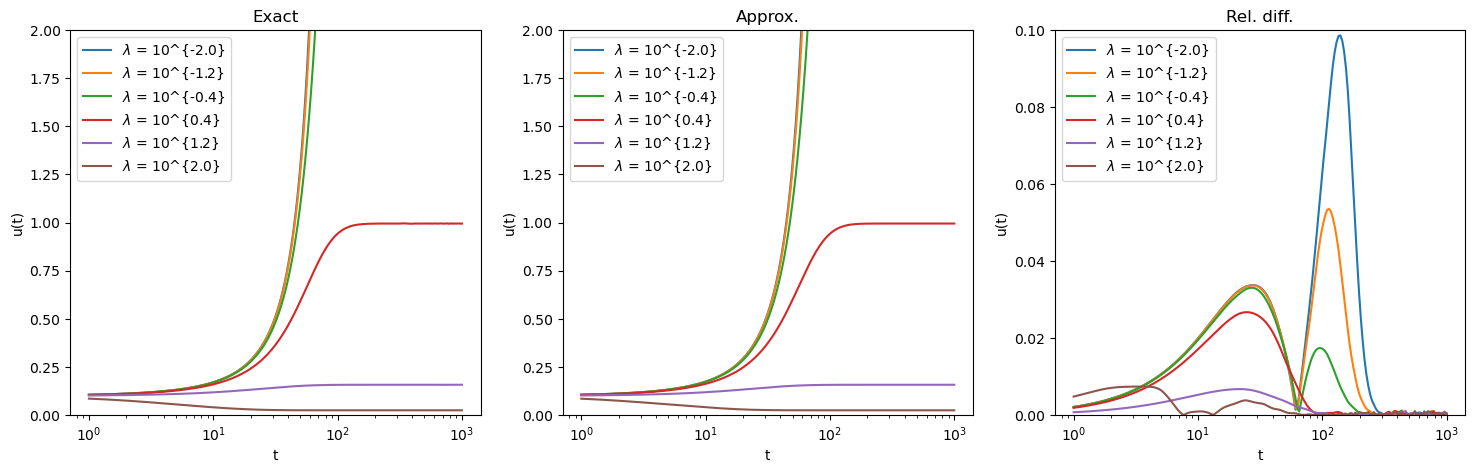

In [31]:
tau = 1000
res = 201
l_min, l_max = 0.01, 100

t_range = np.geomspace(1, tau, res)
l_range = np.geomspace(l_min, l_max, res)
ts, ls = np.meshgrid(t_range, l_range)

c, r = 0.001, 0.01

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s, l_range, q="l")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s, l_range, q="l")

# Vis. 
plot_res(u_ex, u_app, t_range, l_range, it=fr"$\lambda$", vmax=[2.0, 2.0, 0.1], log_y_scale=True, fig_name="change_lambda_gamma_small")
plot_curves(u_ex, u_app, t_range, it_range=l_range, it=r"$\lambda$", ylim=[2.0, 2.0, 0.1], log_y_scale=True, fig_name="change_lambda_gamma_small")


## c = r

C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:15: RuntimeWarning: overflow encountered in exp
  n = s * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) + k1 * c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:16: RuntimeWarning: overflow encountered in exp
  d = l * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) - 2 * k2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:18: RuntimeWarning: invalid value encountered in divide
  return n / d


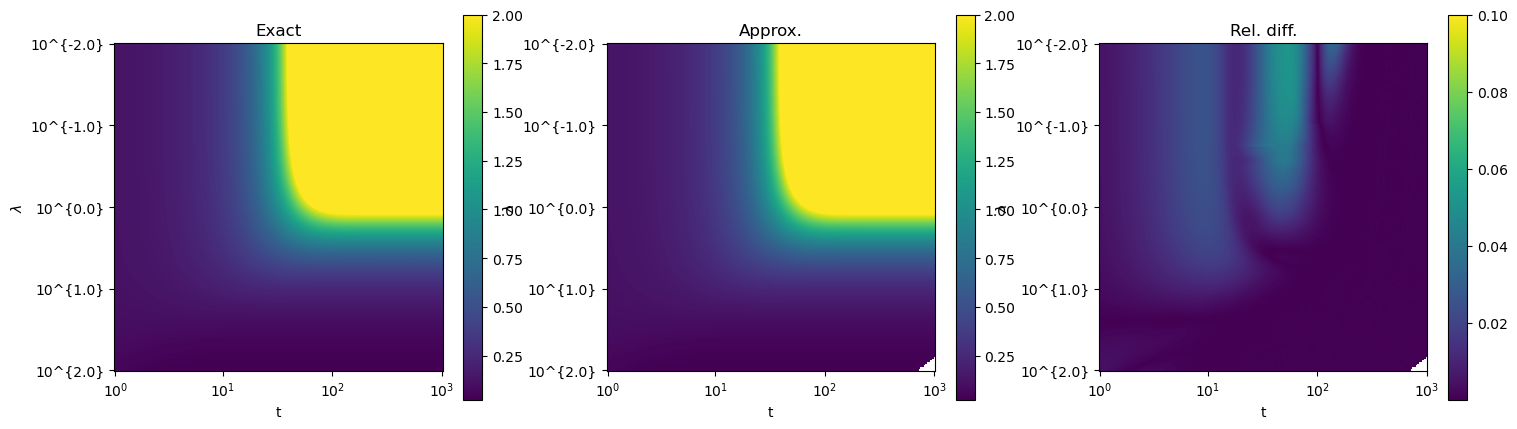

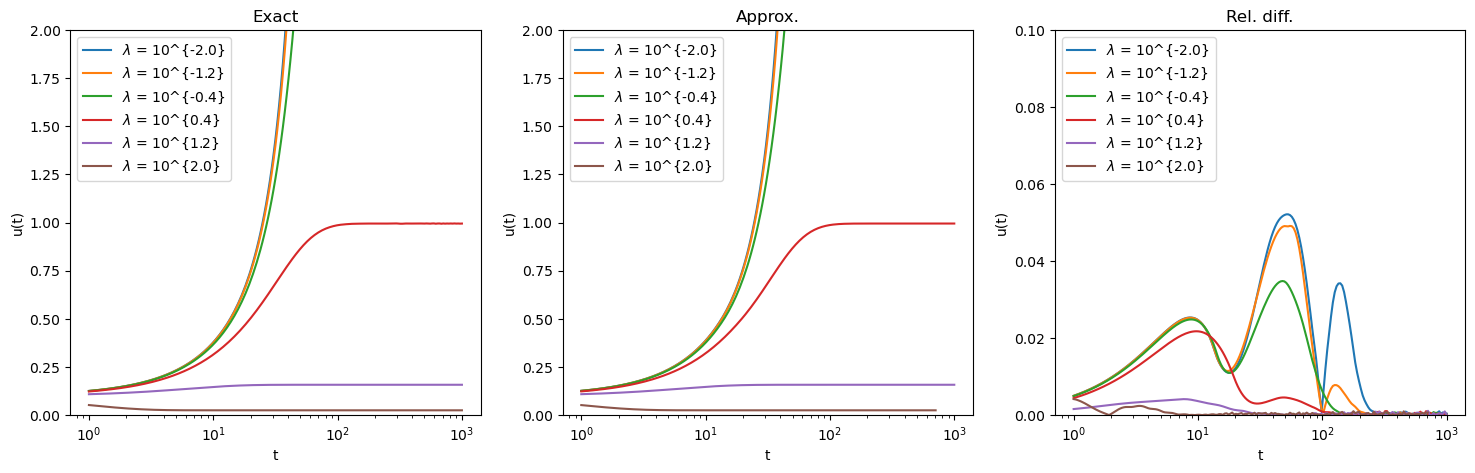

In [32]:
c, r = 0.01, 0.01 # Här är max(ru) = r * s/l, min(ru) = r * u0, så vi kommer att ha ett skifte c > r vid något l

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s, l_range, q="l")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s, l_range, q="l")

# Vis. 
plot_res(u_ex, u_app, t_range, l_range, it=fr"$\lambda$", vmax=[2.0, 2.0, 0.1], fig_name="change_lambda_gamma_equal")
plot_curves(u_ex, u_app, t_range, it_range=l_range, it=r"$\lambda$", ylim=[2.0, 2.0, 0.1], fig_name="change_lambda_gamma_equal")

## c > r

C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:15: RuntimeWarning: overflow encountered in exp
  n = s * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) + k1 * c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:16: RuntimeWarning: overflow encountered in exp
  d = l * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) - 2 * k2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:18: RuntimeWarning: invalid value encountered in divide
  return n / d


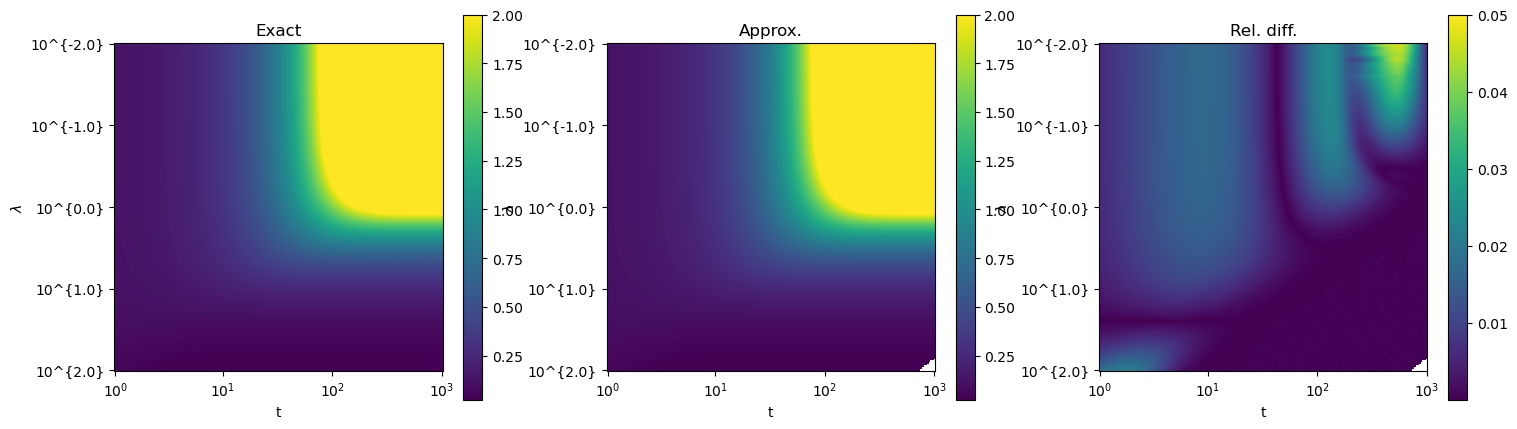

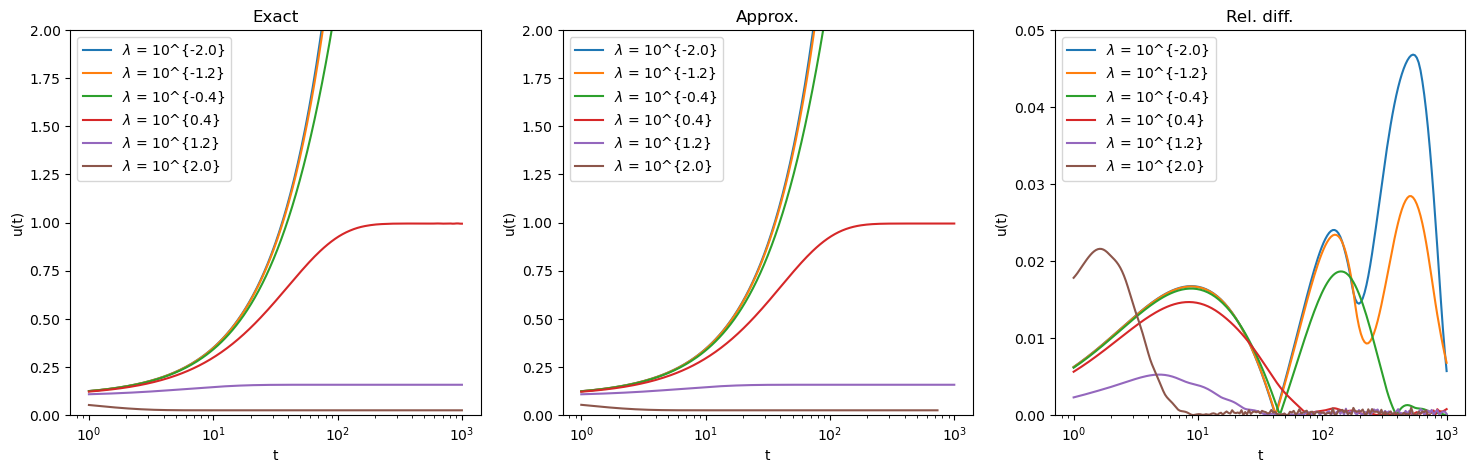

In [33]:
c, r = 0.01, 0.001

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s, l_range, q="l")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s, l_range, q="l")

# Vis. 
plot_res(u_ex, u_app, t_range, l_range, it=fr"$\lambda$", vmax=[2.0, 2.0, 0.05], fig_name="change_lambda_gamma_large")
plot_curves(u_ex, u_app, t_range, it_range=l_range, it=r"$\lambda$", ylim=[2.0, 2.0, 0.05], fig_name="change_lambda_gamma_large")

## c = 0

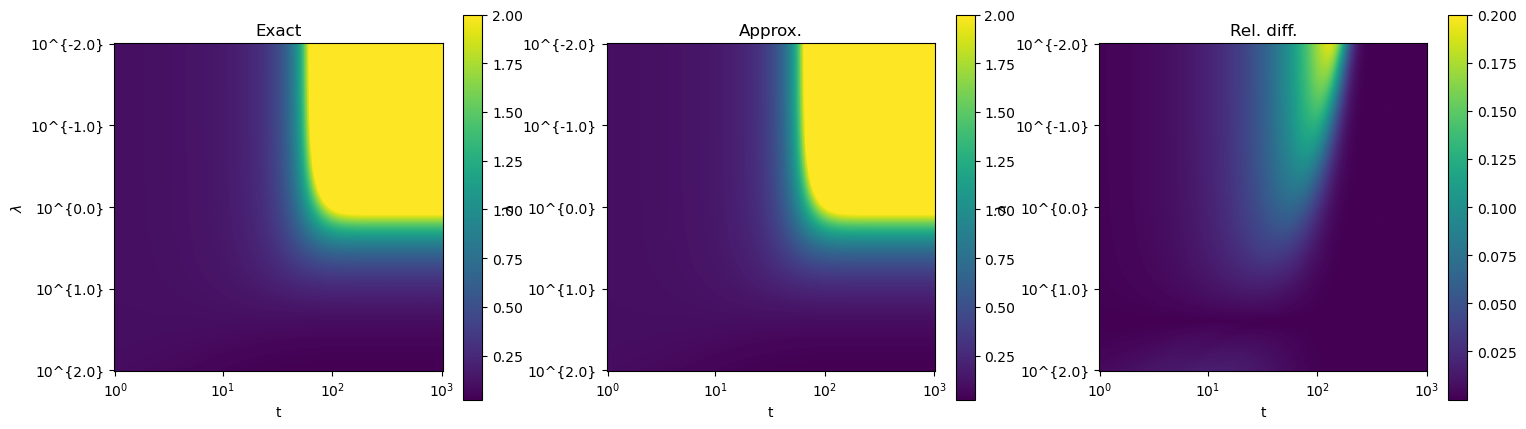

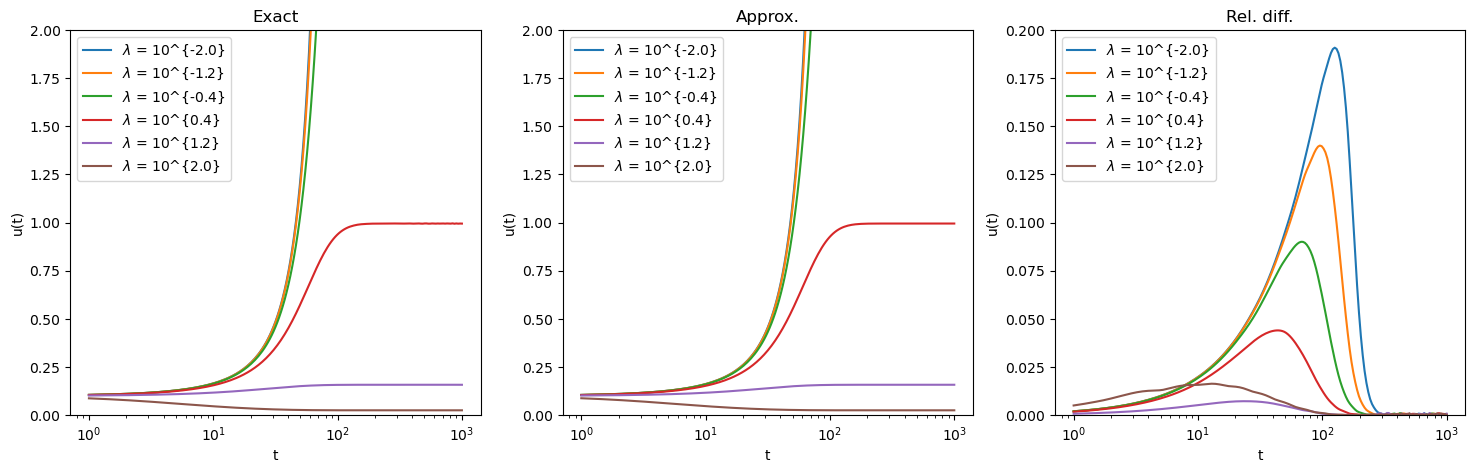

In [34]:
c, r = 0.0, 0.01

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s, l_range, q="l")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s, l_range, q="l")

# Vis. 
plot_res(u_ex, u_app, t_range, l_range, it=fr"$\lambda$", vmax=[2.0, 2.0, 0.2], fig_name="change_lambda_gamma_zero")
plot_curves(u_ex, u_app, t_range, it_range=l_range, it=r"$\lambda$", ylim=[2.0, 2.0, 0.2], fig_name="change_lambda_gamma_zero")

## r = 0

C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:15: RuntimeWarning: overflow encountered in exp
  n = s * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) + k1 * c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:16: RuntimeWarning: overflow encountered in exp
  d = l * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) - 2 * k2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:18: RuntimeWarning: invalid value encountered in divide
  return n / d


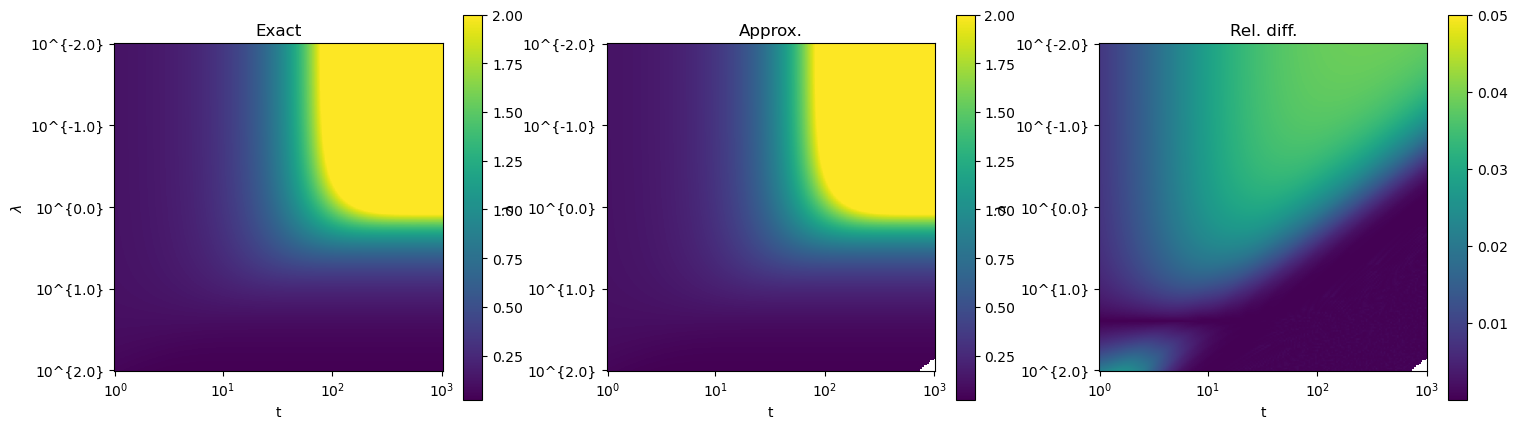

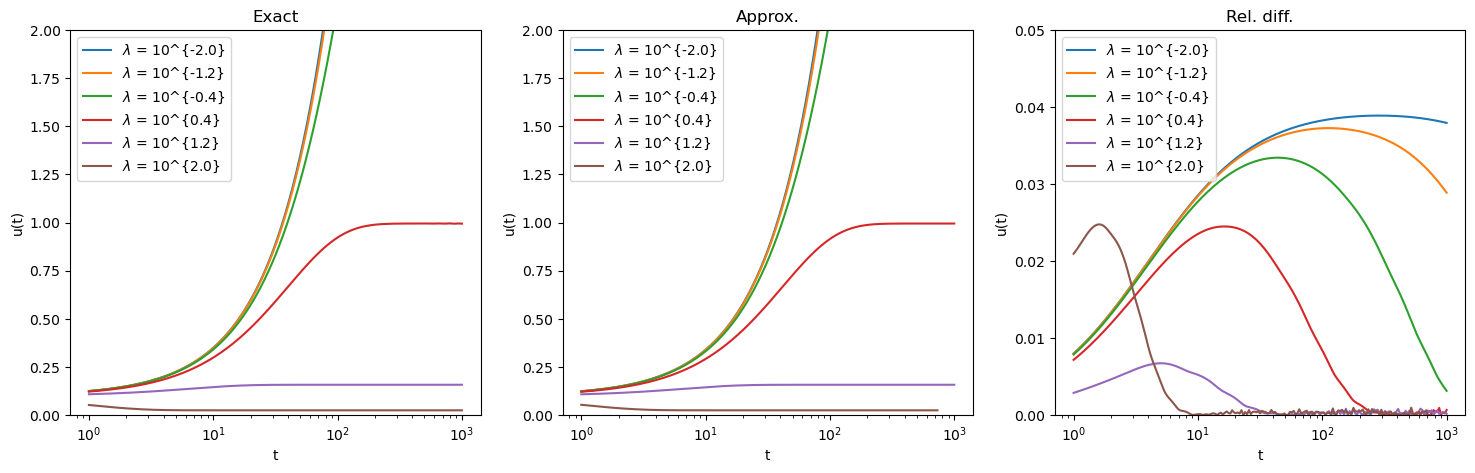

In [35]:
c, r = 0.01, 0.0

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s, l_range, q="l")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s, l_range, q="l")

# Vis. 
plot_res(u_ex, u_app, t_range, l_range, it=fr"$\lambda$", vmax=[2.0, 2.0, 0.05], fig_name="change_lambda_gamma_only")
plot_curves(u_ex, u_app, t_range, it_range=l_range, it=r"$\lambda$", ylim=[2.0, 2.0, 0.05], fig_name="change_lambda_gamma_only")

# Changing $s={\lambda^{(yx)}}^{1/2}$

## c < r

C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:15: RuntimeWarning: overflow encountered in exp
  n = s * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) + k1 * c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:16: RuntimeWarning: overflow encountered in exp
  d = l * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) - 2 * k2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:18: RuntimeWarning: invalid value encountered in divide
  return n / d


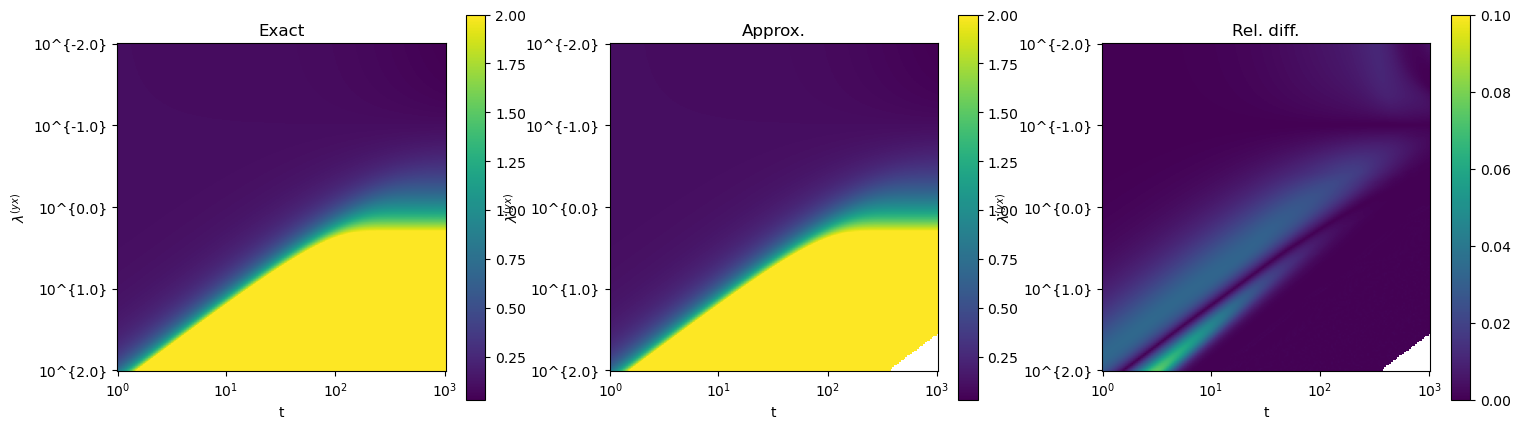

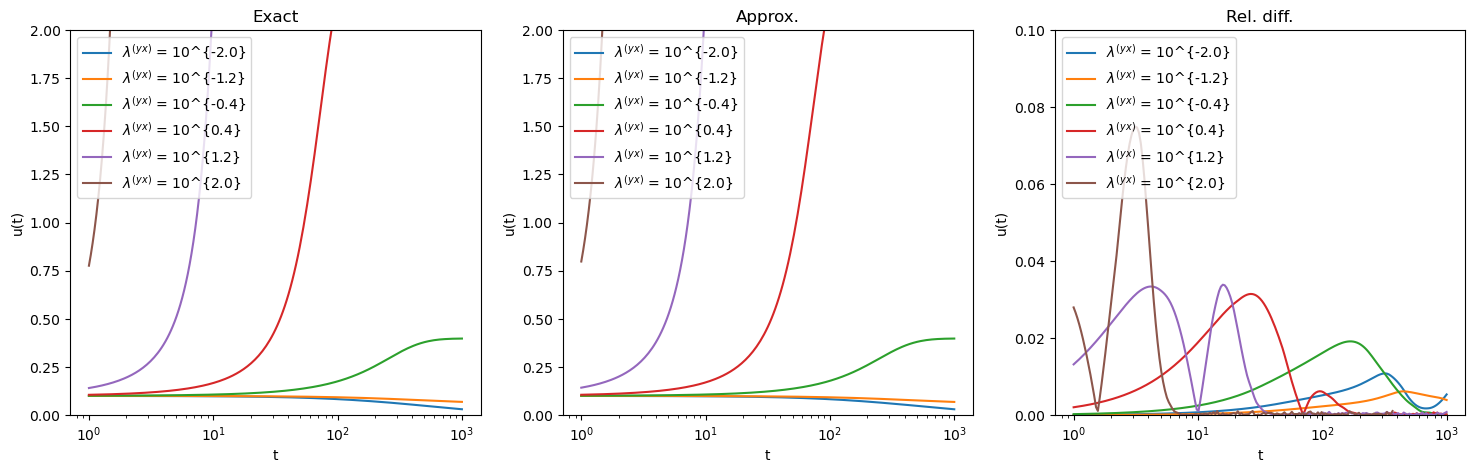

In [36]:
s_min, s_max = 0.01, 100
s_range = np.geomspace(s_min, s_max, res)

ts2, ss = np.meshgrid(t_range, s_range)

c, r = 0.001, 0.01

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s_range, l, q="s")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s_range, l, q="s")

# Vis. 
plot_res(u_ex, u_app, t_range, s_range, it=r"$\lambda^{(yx)}$", vmax=[2.0, 2.0, 0.1], fig_name="change_lambdayx_gamma_small")
plot_curves(u_ex, u_app, t_range, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=[2.0, 2.0, 0.1], fig_name="change_lambdayx_gamma_small")

## c = r

C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:15: RuntimeWarning: overflow encountered in exp
  n = s * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) + k1 * c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:16: RuntimeWarning: overflow encountered in exp
  d = l * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) - 2 * k2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:18: RuntimeWarning: invalid value encountered in divide
  return n / d


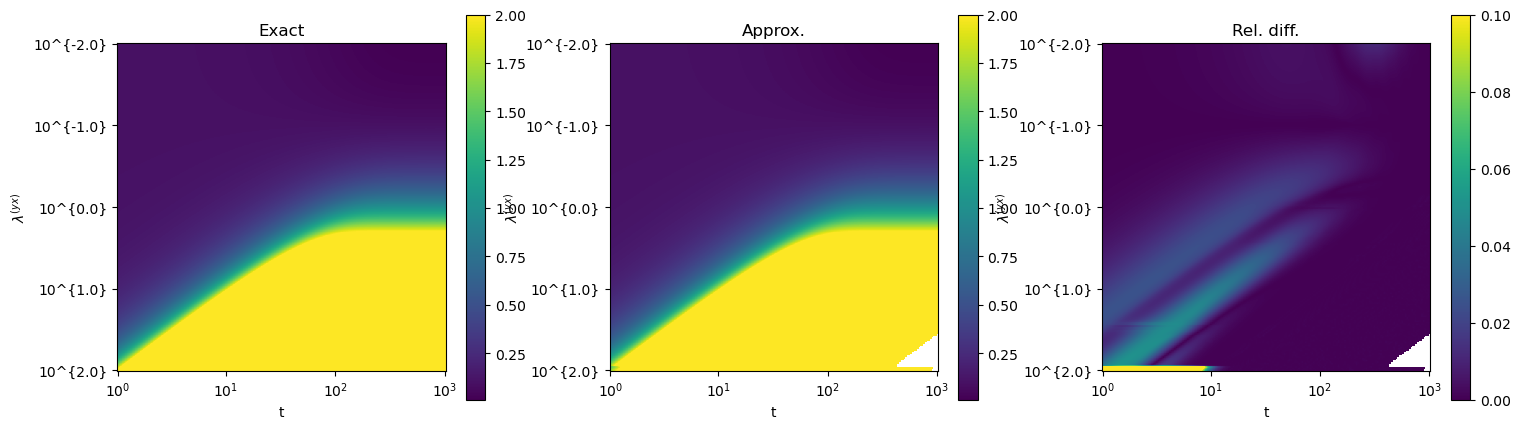

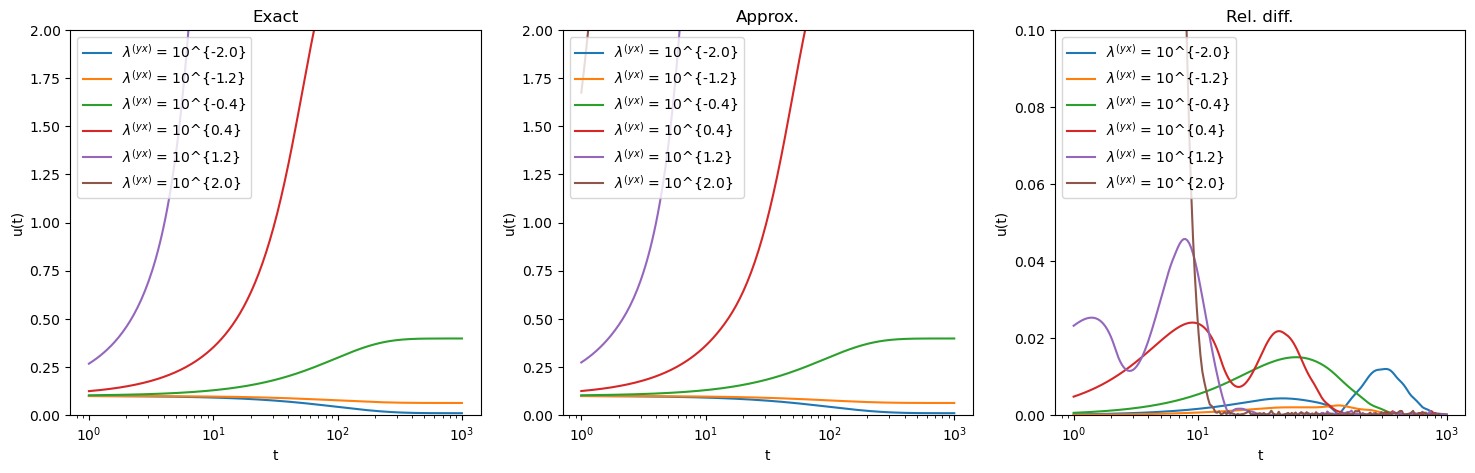

In [37]:
c, r = 0.01, 0.01

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s_range, l, q="s")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s_range, l, q="s")

# Vis. 
plot_res(u_ex, u_app, t_range, s_range, it=r"$\lambda^{(yx)}$", vmax=[2.0, 2.0, 0.1], fig_name="change_lambdayx_gamma_equal")
plot_curves(u_ex, u_app, t_range, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=[2.0, 2.0, 0.1], fig_name="change_lambdayx_gamma_equal")

## c > r

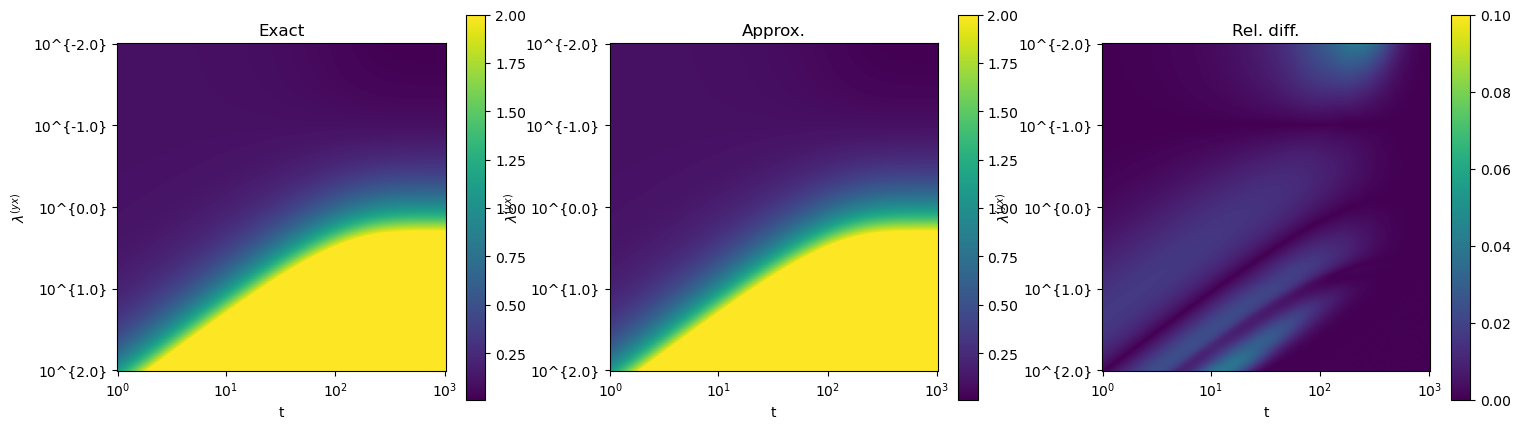

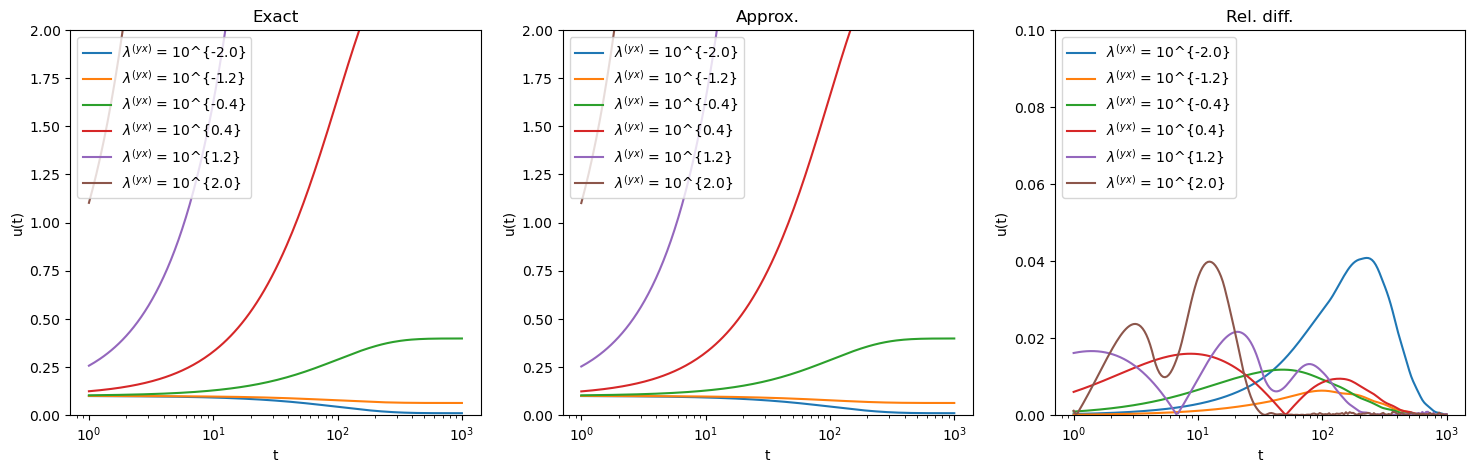

In [38]:
c, r = 0.01, 0.001

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s_range, l, q="s")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s_range, l, q="s")

# Vis. 
plot_res(u_ex, u_app, t_range, s_range, it=r"$\lambda^{(yx)}$", vmax=[2.0, 2.0, 0.1], fig_name="change_lambdayx_gamma_large")
plot_curves(u_ex, u_app, t_range, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=[2.0, 2.0, 0.1], fig_name="change_lambdayx_gamma_large")

## c = 0

C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:15: RuntimeWarning: overflow encountered in exp
  n = s * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) + k1 * c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:16: RuntimeWarning: overflow encountered in exp
  d = l * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) - 2 * k2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:18: RuntimeWarning: invalid value encountered in divide
  return n / d


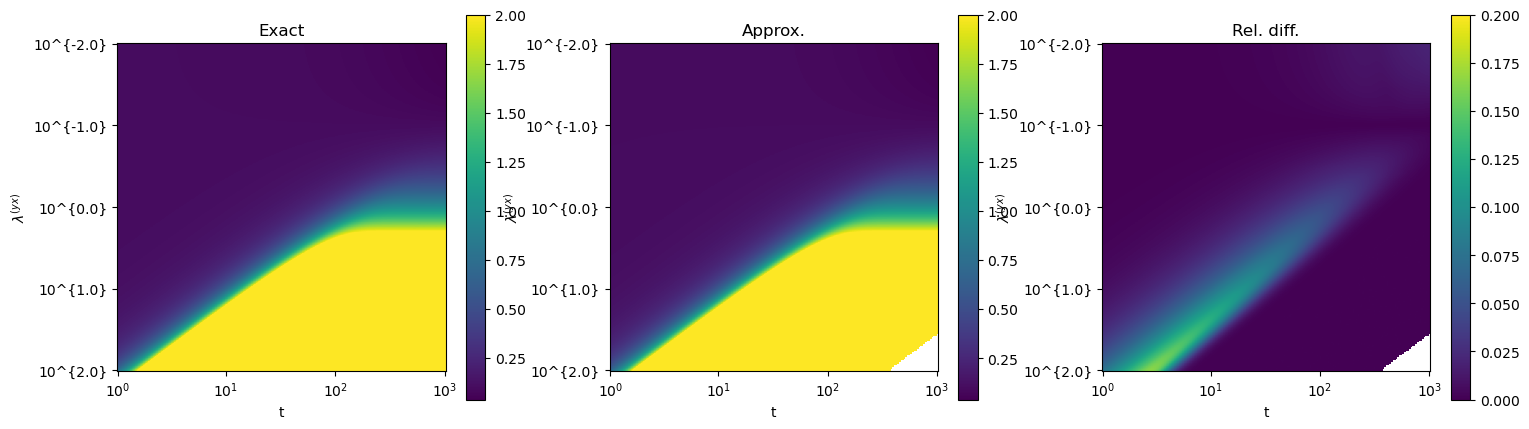

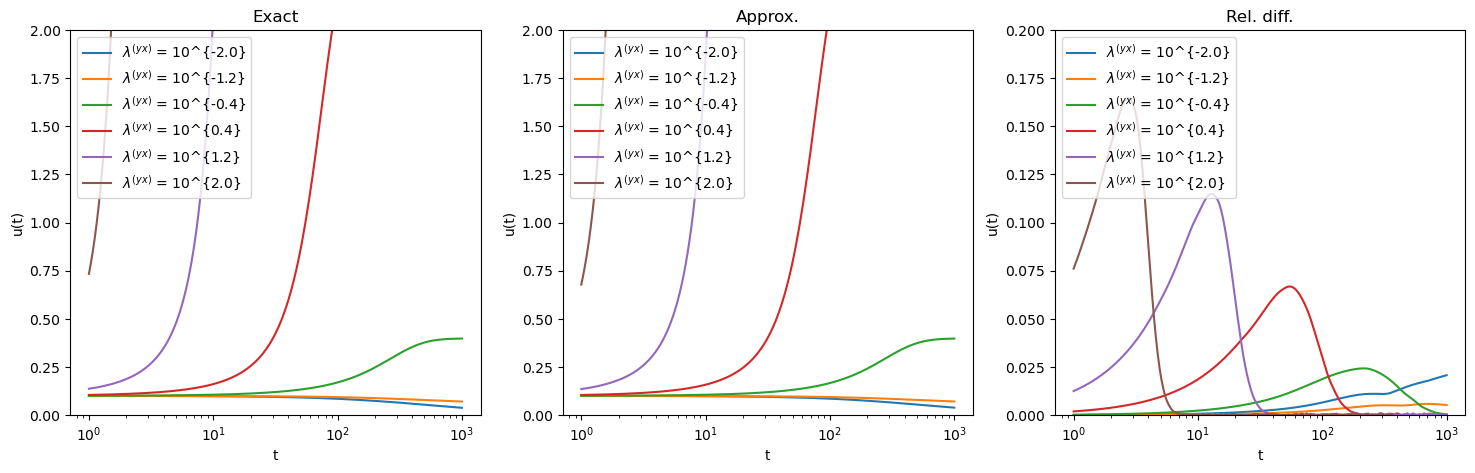

In [39]:
c, r = 0.0, 0.01

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s_range, l, q="s")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s_range, l, q="s")

# Vis. 
plot_res(u_ex, u_app, t_range, s_range, it=r"$\lambda^{(yx)}$", vmax=[2.0, 2.0, 0.2], fig_name="change_lambdayx_gamma_zero")
plot_curves(u_ex, u_app, t_range, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=[2.0, 2.0, 0.2], fig_name="change_lambdayx_gamma_zero")

## r = 0

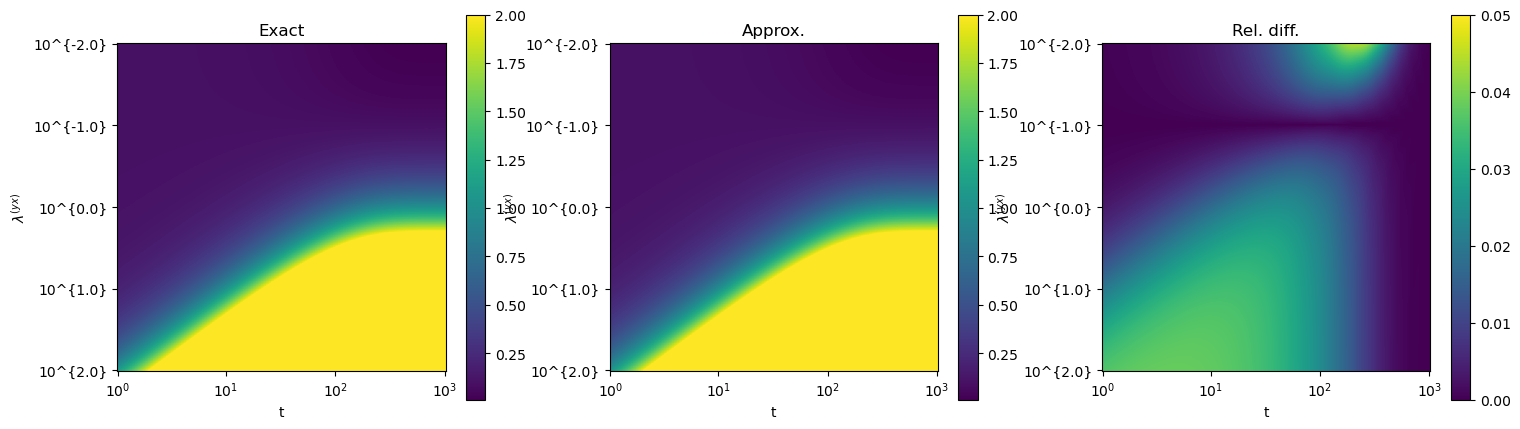

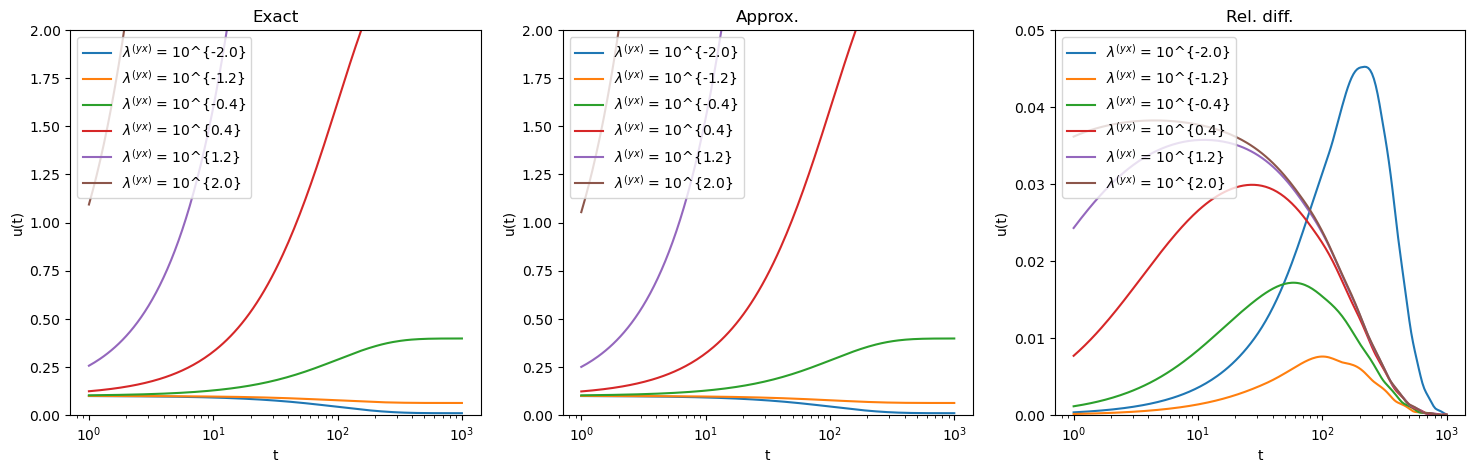

In [40]:
c, r = 0.01, 0.0

# "Exact"
u_ex = loop_dynamics(u0, t_range, c, r, s_range, l, q="s")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c, r, s_range, l, q="s")

# Vis. 
plot_res(u_ex, u_app, t_range, s_range, it=r"$\lambda^{(yx)}$", vmax=[2.0, 2.0, 0.05], fig_name="change_lambdayx_gamma_only")
plot_curves(u_ex, u_app, t_range, it_range=s_range, it=r"$\lambda^{(yx)}$", ylim=[2.0, 2.0, 0.05], fig_name="change_lambdayx_gamma_only")

# Changing $u0=u(0)$

## c < r

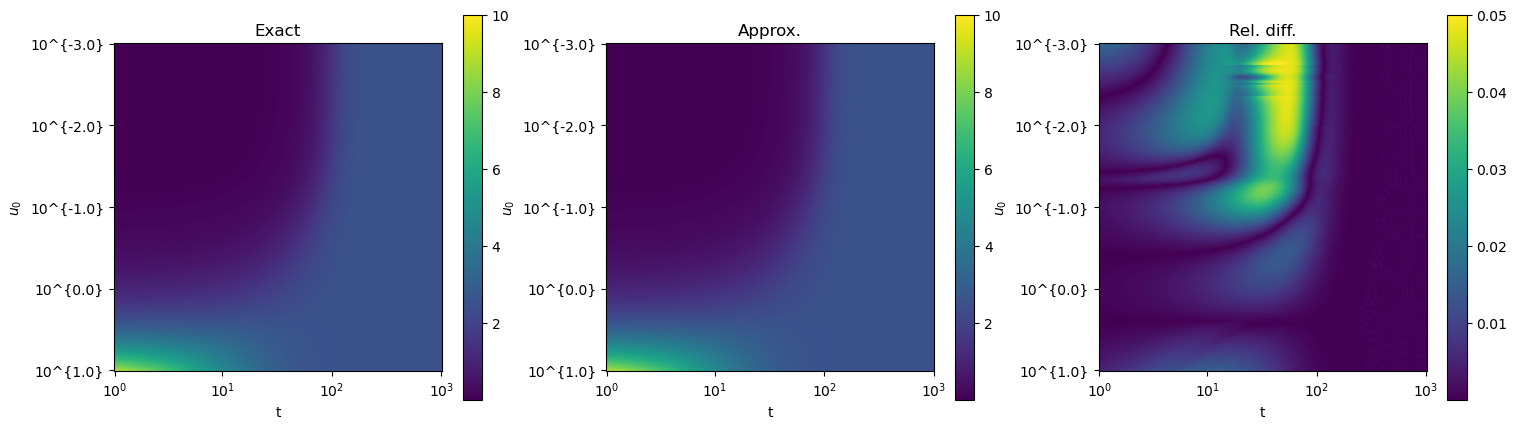

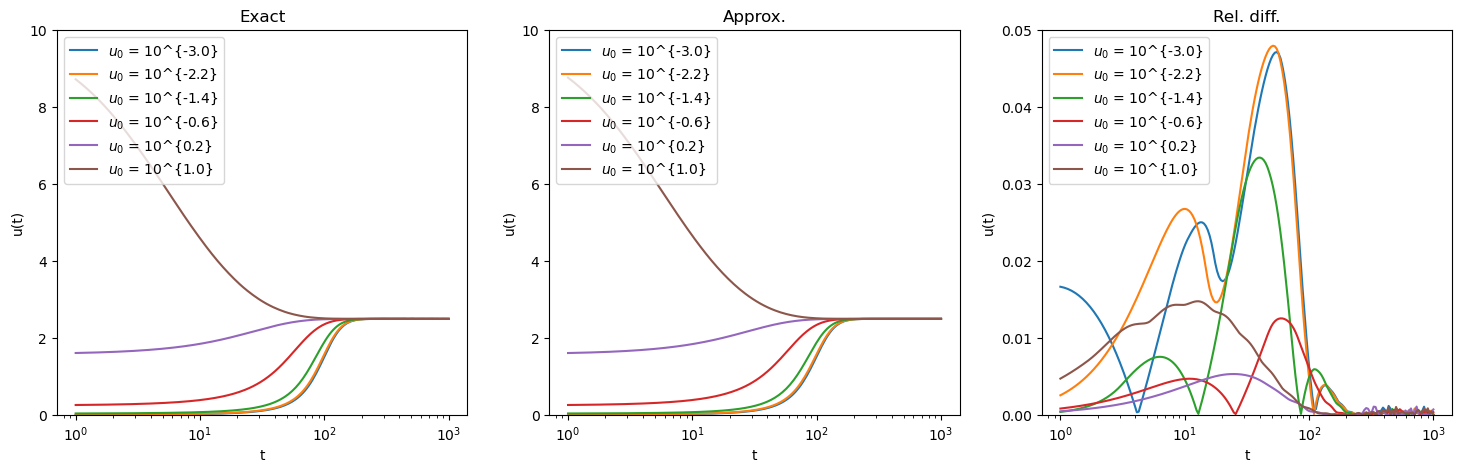

In [41]:
u0_min, u0_max = 0.001, 10
u0_range = np.geomspace(u0_min, u0_max, res)

ts3, u0s = np.meshgrid(t_range, u0_range)

c, r = 0.001, 0.01

# "Exact"
u_ex = loop_dynamics(u0_range, t_range, c, r, s, l, q="u0")

# Approx.
u_app = loop_dynamics_approx(u0_range, t_range, c, r, s, l, q="u0") 


# Vis. 
plot_res(u_ex, u_app, t_range, u0_range, it=r"$u_0$", vmax=[10.0, 10.0, 0.05], fig_name="change_u0_gamma_small")
plot_curves(u_ex, u_app, t_range, it_range=u0_range, it=r"$u_0$", ylim=[10.0, 10.0, 0.05], log_y_scale=True, fig_name="change_u0_gamma_small")

## c = r

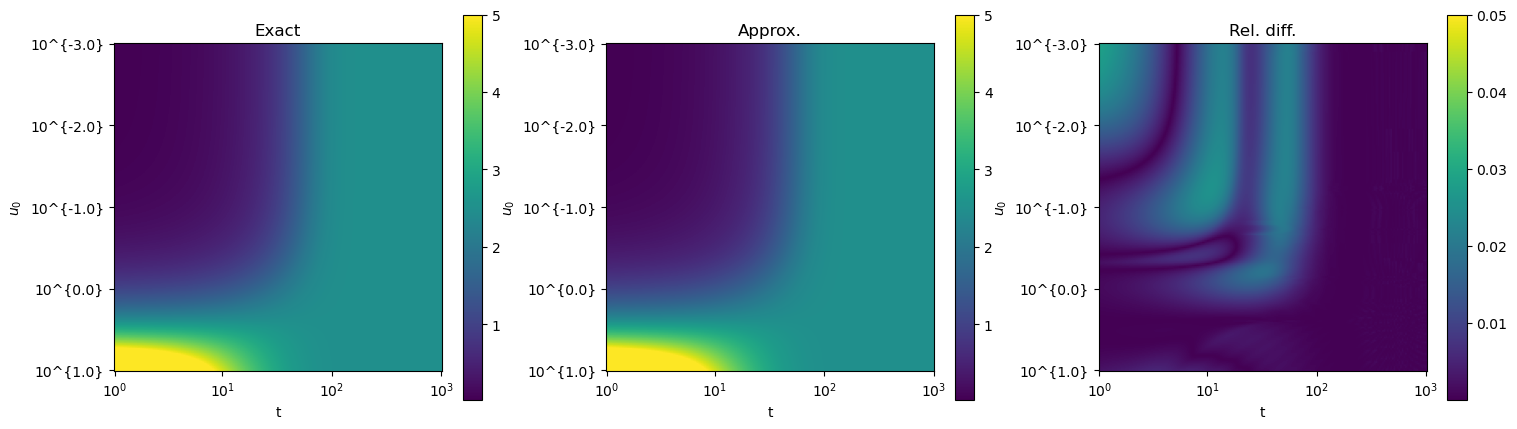

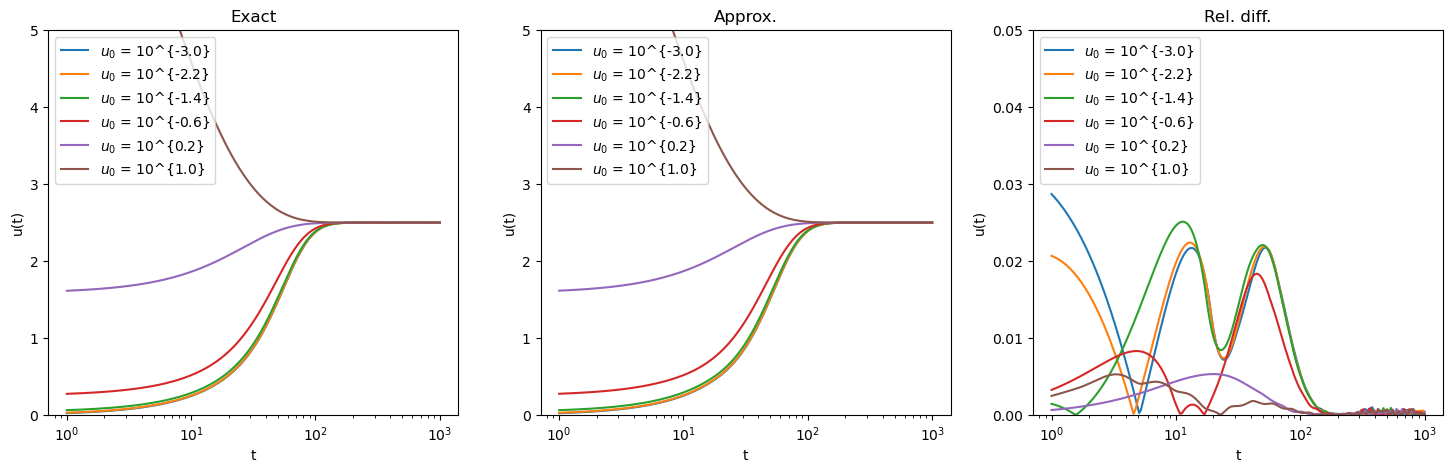

In [42]:
c, r = 0.01, 0.01

# "Exact"
u_ex = loop_dynamics(u0_range, t_range, c, r, s, l, q="u0")

# Approx.
u_app = loop_dynamics_approx(u0_range, t_range, c, r, s, l, q="u0") 

# Vis. 
plot_res(u_ex, u_app, t_range, u0_range, it=r"$u_0$", vmax=[5.0, 5.0, 0.05], fig_name="change_u0_gamma_equal")
plot_curves(u_ex, u_app, t_range, it_range=u0_range, it=r"$u_0$", ylim=[5.0, 5.0, 0.05], fig_name="change_u0_gamma_equal")

## c > r

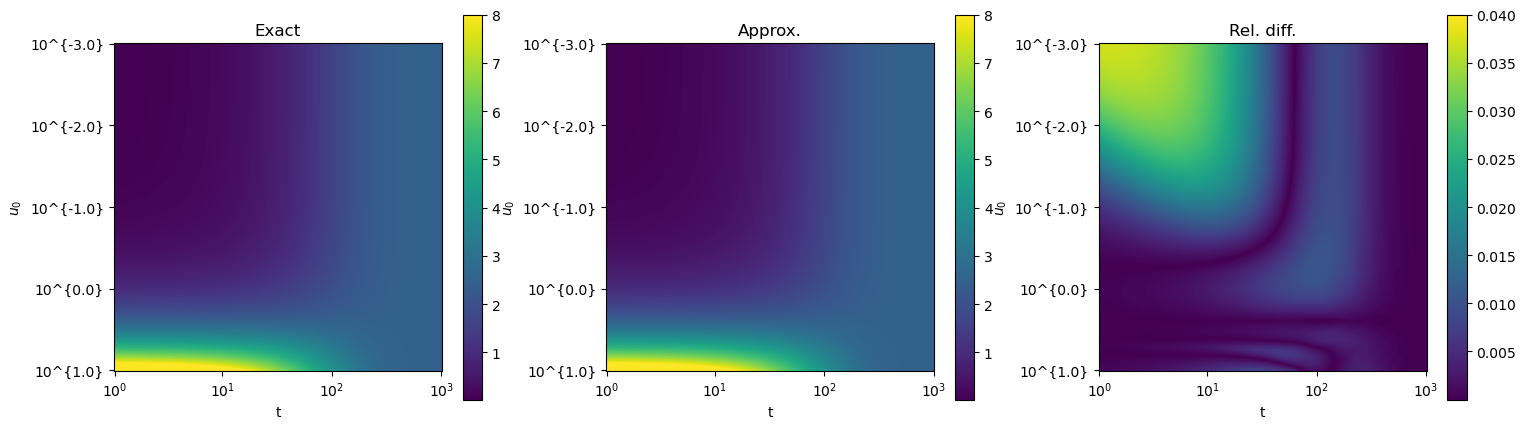

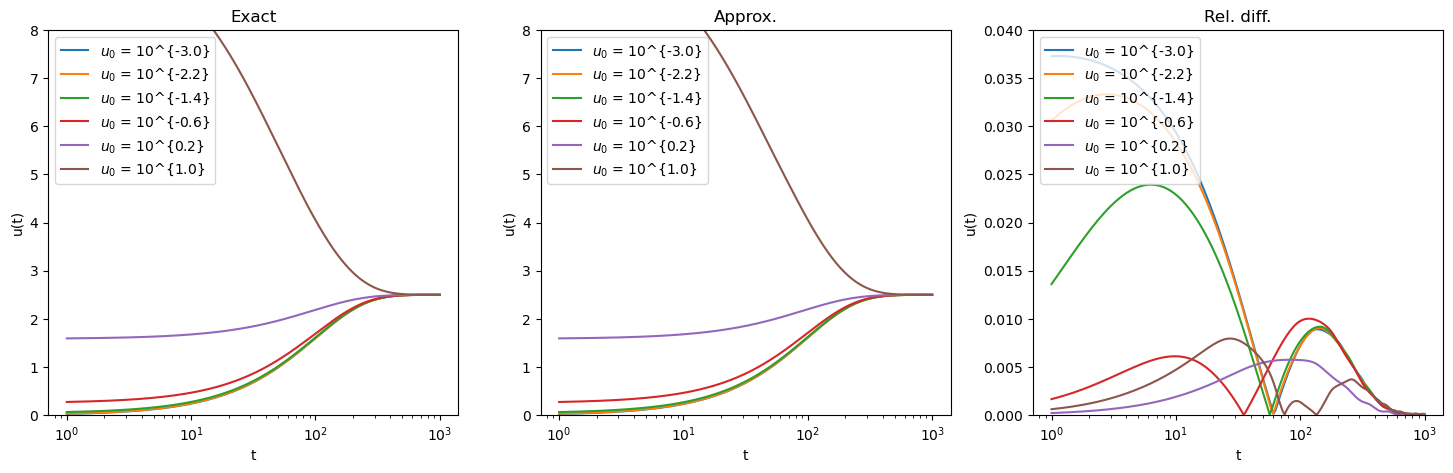

In [43]:
c, r = 0.01, 0.001

# "Exact"
u_ex = loop_dynamics(u0_range, t_range, c, r, s, l, q="u0")

# Approx.
u_app = loop_dynamics_approx(u0_range, t_range, c, r, s, l, q="u0") 

# Vis. 
plot_res(u_ex, u_app, t_range, u0_range, it=r"$u_0$", vmax=[8.0, 8.0, 0.04], fig_name="change_u0_gamma_large")
plot_curves(u_ex, u_app, t_range, it_range=u0_range, it=r"$u_0$", ylim=[8.0, 8.0, 0.04], fig_name="change_u0_gamma_large")

## c = 0

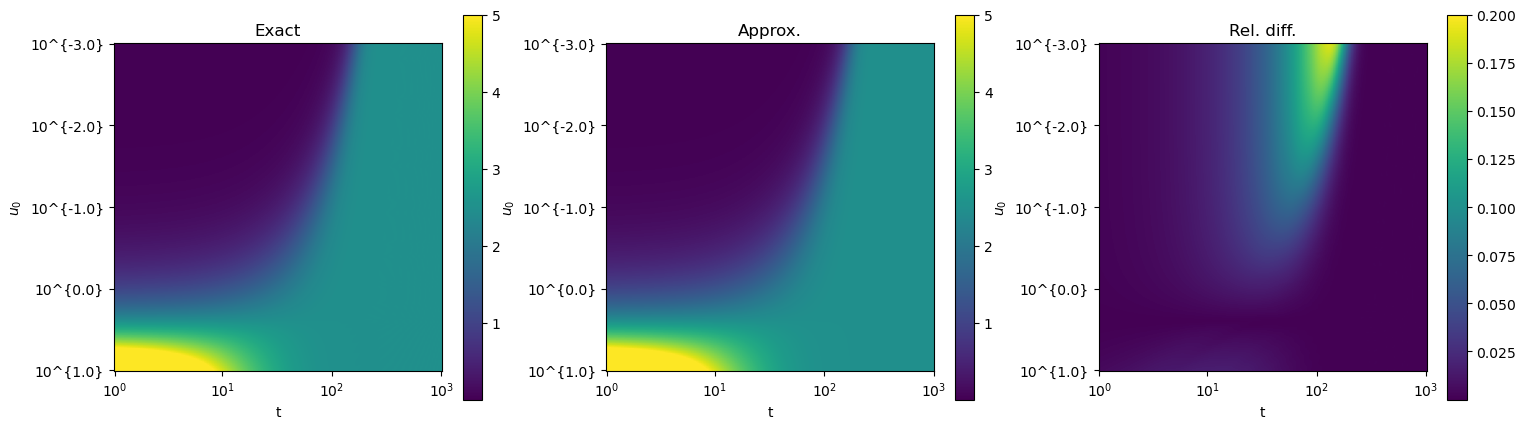

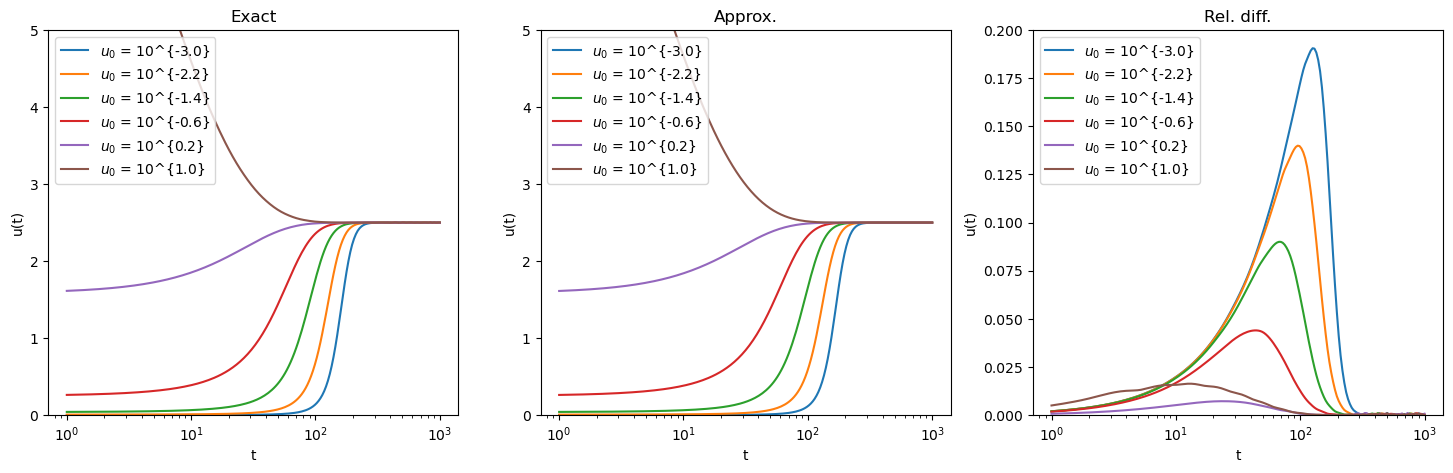

In [44]:
## c = r

c, r = 0.0, 0.01

# "Exact"
u_ex = loop_dynamics(u0_range, t_range, c, r, s, l, q="u0")

# Approx.
u_app = loop_dynamics_approx(u0_range, t_range, c, r, s, l, q="u0") 

# Vis. 
plot_res(u_ex, u_app, t_range, u0_range, it=r"$u_0$", vmax=[5.0, 5.0, 0.2], fig_name="change_u0_gamma_zero")
plot_curves(u_ex, u_app, t_range, it_range=u0_range, it=r"$u_0$", ylim=[5.0, 5.0, 0.2], fig_name="change_u0_gamma_zero")

## r = 0

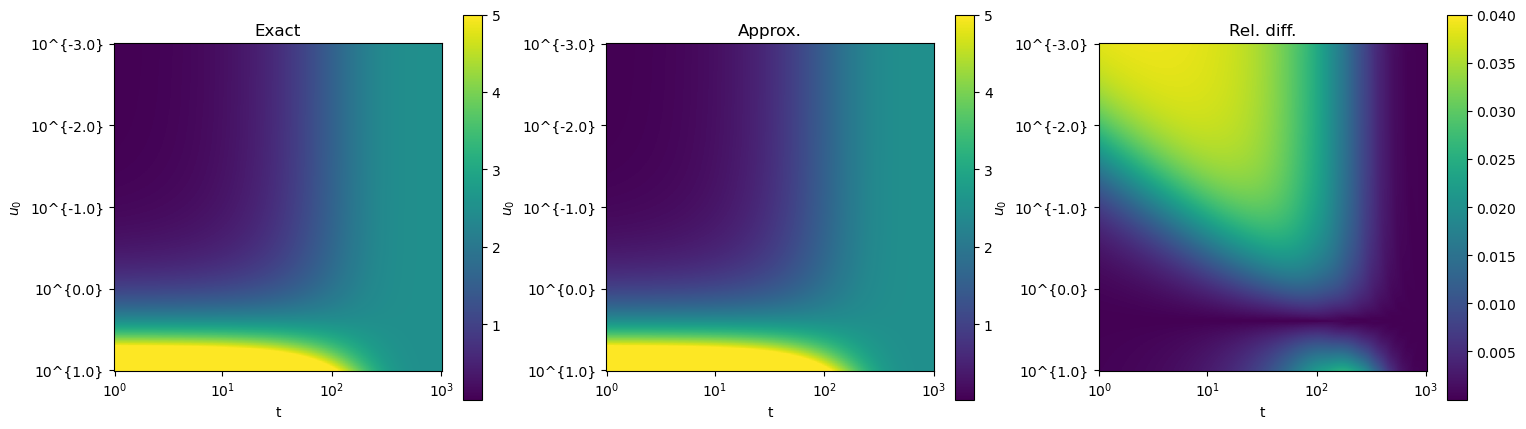

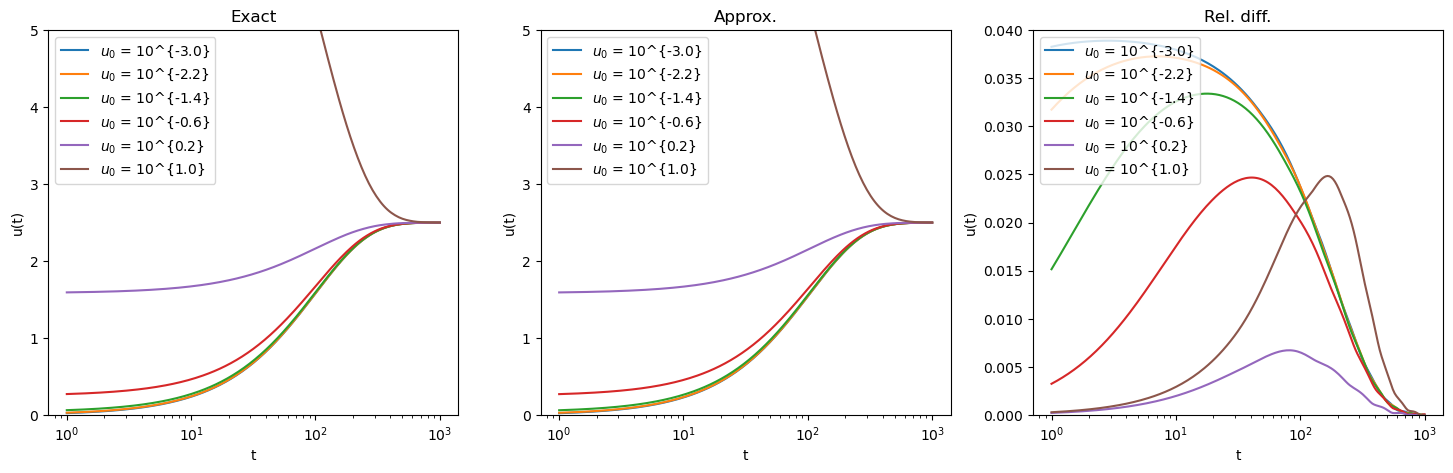

In [45]:
c, r = 0.01, 0.0

# "Exact"
u_ex = loop_dynamics(u0_range, t_range, c, r, s, l, q="u0")

# Approx.
u_app = loop_dynamics_approx(u0_range, t_range, c, r, s, l, q="u0") 

# Vis. 
plot_res(u_ex, u_app, t_range, u0_range, it=r"$u_0$", vmax=[5.0, 5.0, 0.04], log_y_scale=True, fig_name="change_u0_gamma_only")
plot_curves(u_ex, u_app, t_range, it_range=u0_range, it=r"$u_0$", ylim=[5.0, 5.0, 0.04], log_y_scale=True, fig_name="change_u0_gamma_only")

# Changing $r=\sqrt{\eta_a \eta_b}$

C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:15: RuntimeWarning: overflow encountered in exp
  n = s * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) + k1 * c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:16: RuntimeWarning: overflow encountered in exp
  d = l * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) - 2 * k2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:18: RuntimeWarning: invalid value encountered in divide
  return n / d


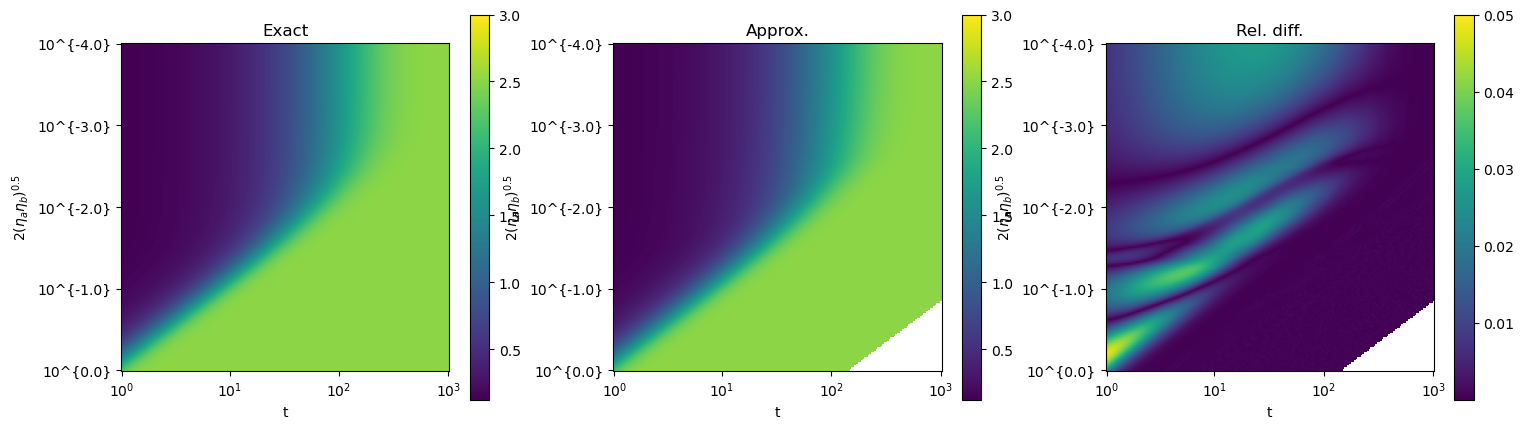

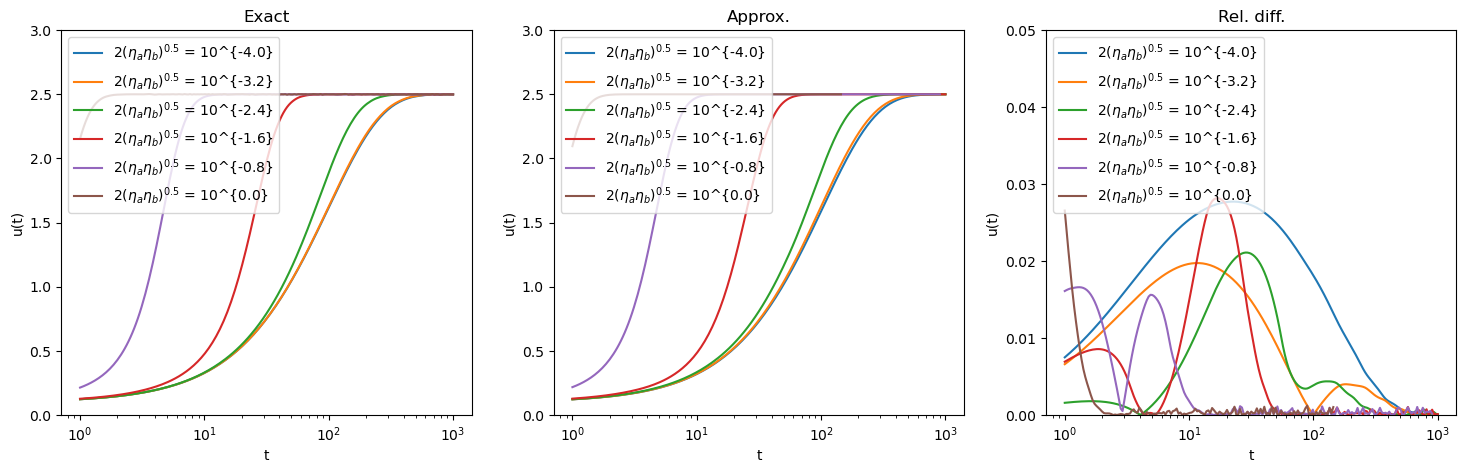

In [46]:
c = 0.01

r_min, r_max = 0.0001, 1.0
r_range = np.geomspace(r_min, r_max, res)
ts4, rs = np.meshgrid(t_range, r_range)

# "Exact"
u_ex = loop_dynamics(u0, t_range, [c] * r_range.shape[0], r_range, s, l, q="rc")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, [c] * r_range.shape[0], r_range, s, l, q="rc") 

# Vis. 
plot_res(u_ex, u_app, t_range, r_range, it=fr"$2 (\eta_a \eta_b)^{{{1/2}}}$", vmax=[3.0, 3.0, 0.05], fig_name="change_lr_gamma_fixed")
plot_curves(u_ex, u_app, t_range, it_range=r_range, it=fr"$2 (\eta_a \eta_b)^{{{1/2}}}$", ylim=[3.0, 3.0, 0.05], fig_name="change_lr_gamma_fixed")


# Changing $c = \gamma$

C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:15: RuntimeWarning: overflow encountered in exp
  n = s * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) + k1 * c * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:16: RuntimeWarning: overflow encountered in exp
  d = l * (k1 * c + 2 * k2 * r * u0) * np.exp((k1 * c * l + 2 * k2 * r * s) * t) - 2 * k2 * r * (l * u0 - s)
C:\Users\amaol67\AppData\Local\Temp\ipykernel_14776\2768089241.py:18: RuntimeWarning: invalid value encountered in divide
  return n / d


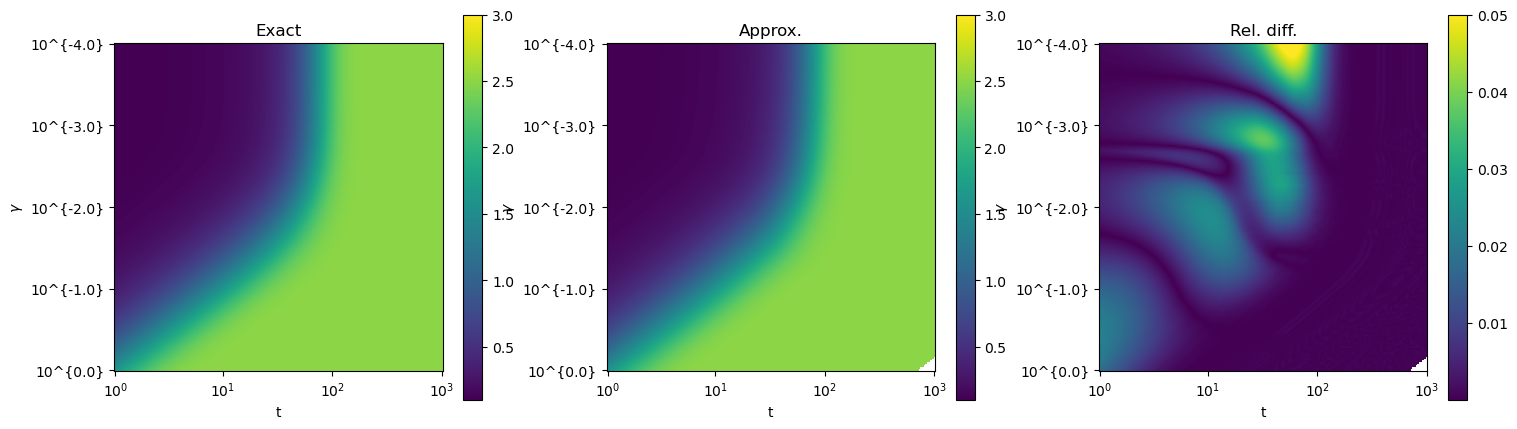

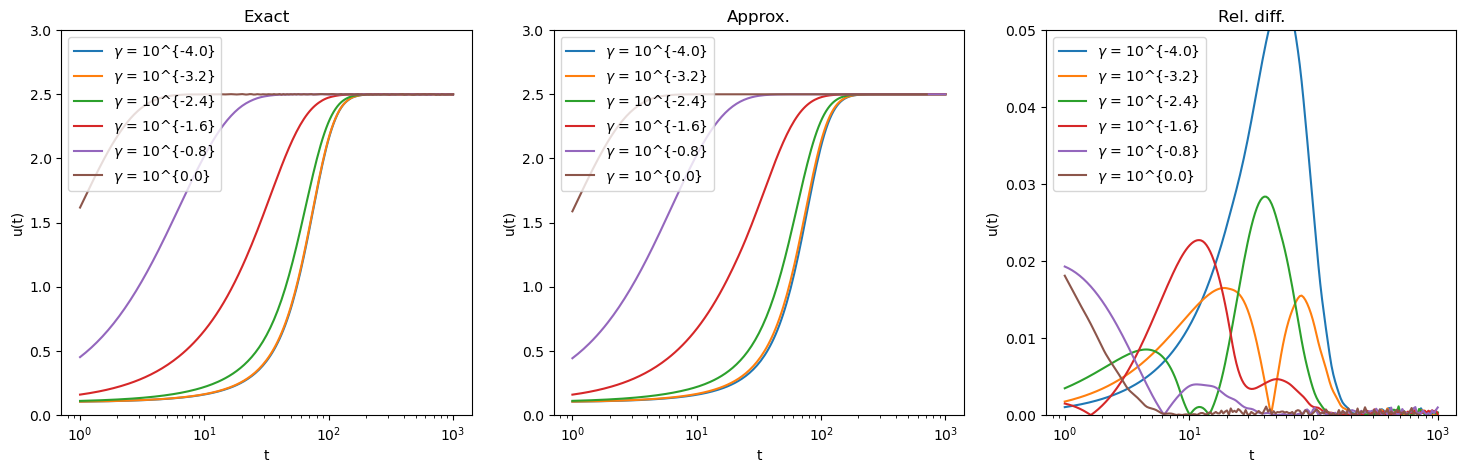

In [47]:
r = 0.01

c_min, c_max = 0.0001, 1.0
c_range = np.geomspace(c_min, c_max, res)
ts4, cs = np.meshgrid(t_range, c_range)

# "Exact"
u_ex = loop_dynamics(u0, t_range, c_range, [r] * c_range.shape[0], s, l, q="rc")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c_range, [r] * c_range.shape[0], s, l, q="rc") 

# Vis. 
plot_res(u_ex, u_app, t_range, c_range, it=fr"$\gamma$", vmax=[3.0, 3.0, 0.05], fig_name="change_gamma")
plot_curves(u_ex, u_app, t_range, it_range=c_range, it=r"$\gamma$", ylim=[3.0, 3.0, 0.05], fig_name="change_gamma")


# Changing r + c

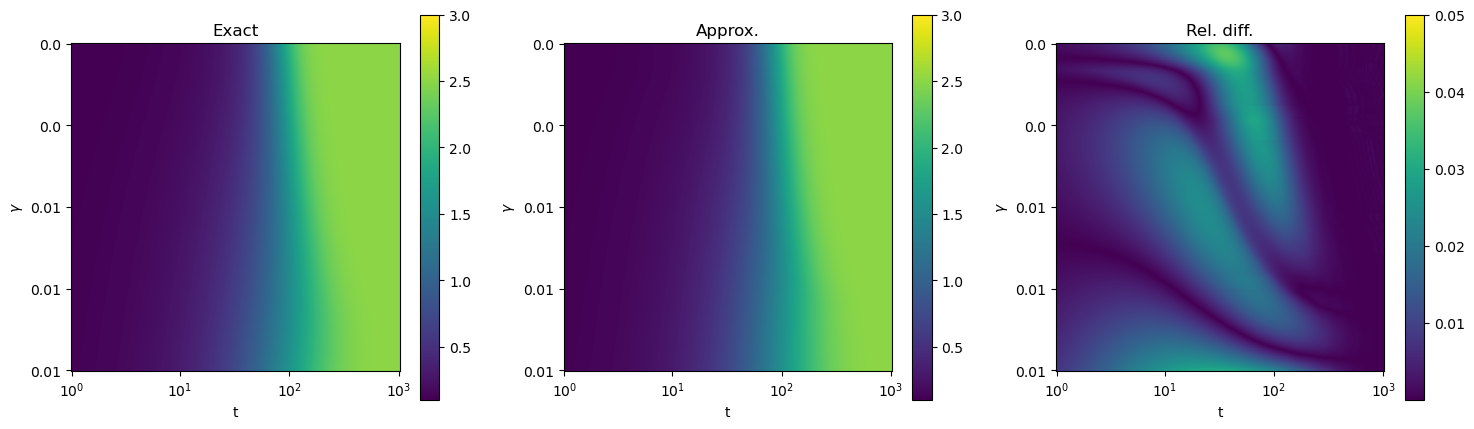

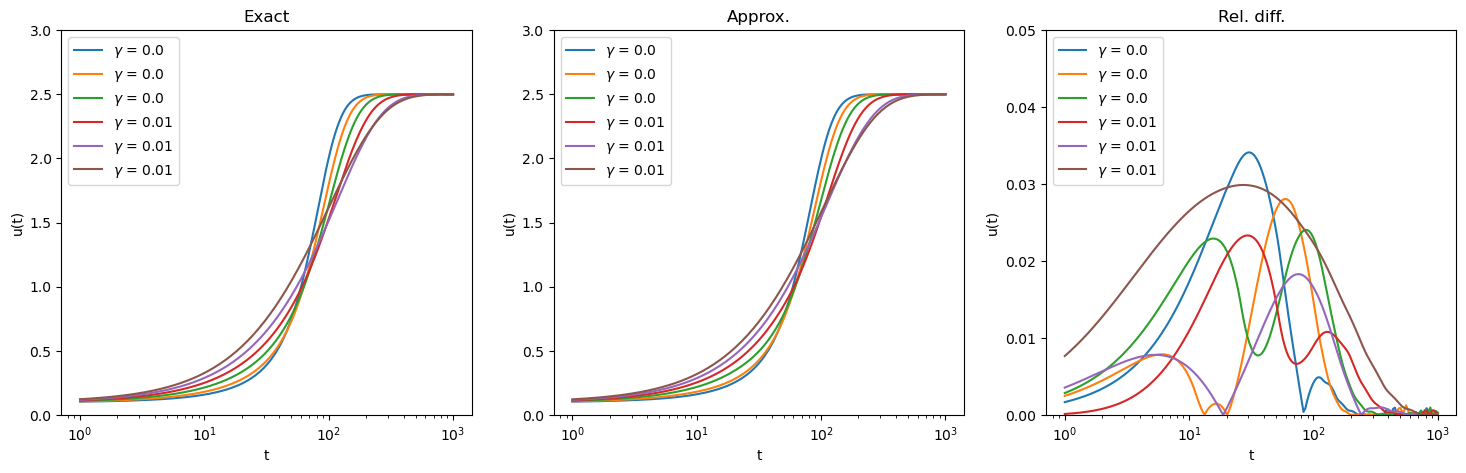

In [48]:
c_max = 0.01
c_range = np.linspace(0.001, c_max, res)
ts4, cs = np.meshgrid(t_range, c_range)

# "Exact"
u_ex = loop_dynamics(u0, t_range, c_range, c_max-c_range, s, l, q="rc")

# Approx.
u_app = loop_dynamics_approx(u0, t_range, c_range, c_max - c_range, s, l, q="rc") 

# Vis. 
plot_res(u_ex, u_app, t_range, c_range, it=r"$\gamma$", vmax=[3.0, 3.0, 0.05], log_y_scale=False)
plot_curves(u_ex, u_app, t_range, it_range=c_range, it=r"$\gamma$", ylim=[3.0, 3.0, 0.05], log_y_scale=False)
